In [1]:
import pandas as pd
from datetime import datetime
from tqdm import tqdm

import time
import requests
import datetime
import pandas as pd
from collections import defaultdict
from typing import Any, Union
from string import Template
from enum import Enum
from tqdm import tqdm
import numpy as np
from pathlib import Path

In [2]:
tools = pd.read_parquet('/Users/arshath/play/openautonomy/olas-prediction-live-dashboard/data/tools.parquet')
tools['trader_address'] = tools['trader_address'].str.lower()
fpmmTrades = pd.read_parquet('/Users/arshath/play/openautonomy/olas-prediction-live-dashboard/data/fpmmTrades.parquet')
# trades = pd.read_parquet('/Users/arshath/play/openautonomy/olas-prediction-live-dashboard/data/all_trades_profitability.parquet')

In [ ]:
IRRELEVANT_TOOLS = [
    "openai-text-davinci-002",
    "openai-text-davinci-003",
    "openai-gpt-3.5-turbo",
    "openai-gpt-4",
    "stabilityai-stable-diffusion-v1-5",
    "stabilityai-stable-diffusion-xl-beta-v2-2-2",
    "stabilityai-stable-diffusion-512-v2-1",
    "stabilityai-stable-diffusion-768-v2-1",
    "deepmind-optimization-strong",
    "deepmind-optimization",
]
QUERY_BATCH_SIZE = 1000
DUST_THRESHOLD = 10000000000000
INVALID_ANSWER_HEX = (
    "0xffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff"
)
INVALID_ANSWER = -1
FPMM_CREATOR = "0x89c5cc945dd550bcffb72fe42bff002429f46fec"
DEFAULT_FROM_DATE = "1970-01-01T00:00:00"
DEFAULT_TO_DATE = "2038-01-19T03:14:07"
DEFAULT_FROM_TIMESTAMP = 0
DEFAULT_TO_TIMESTAMP = 2147483647
WXDAI_CONTRACT_ADDRESS = "0xe91D153E0b41518A2Ce8Dd3D7944Fa863463a97d"
DEFAULT_MECH_FEE = 0.01
DUST_THRESHOLD = 10000000000000
SCRIPTS_DIR = Path('/Users/arshath/play/openautonomy/olas-prediction-live-dashboard/scripts')
ROOT_DIR = SCRIPTS_DIR.parent
DATA_DIR = ROOT_DIR / "data"

class MarketState(Enum):
    """Market state"""

    OPEN = 1
    PENDING = 2
    FINALIZING = 3
    ARBITRATING = 4
    CLOSED = 5

    def __str__(self) -> str:
        """Prints the market status."""
        return self.name.capitalize()


class MarketAttribute(Enum):
    """Attribute"""

    NUM_TRADES = "Num_trades"
    WINNER_TRADES = "Winner_trades"
    NUM_REDEEMED = "Num_redeemed"
    INVESTMENT = "Investment"
    FEES = "Fees"
    MECH_CALLS = "Mech_calls"
    MECH_FEES = "Mech_fees"
    EARNINGS = "Earnings"
    NET_EARNINGS = "Net_earnings"
    REDEMPTIONS = "Redemptions"
    ROI = "ROI"

    def __str__(self) -> str:
        """Prints the attribute."""
        return self.value

    def __repr__(self) -> str:
        """Prints the attribute representation."""
        return self.name

    @staticmethod
    def argparse(s: str) -> "MarketAttribute":
        """Performs string conversion to MarketAttribute."""
        try:
            return MarketAttribute[s.upper()]
        except KeyError as e:
            raise ValueError(f"Invalid MarketAttribute: {s}") from e


ALL_TRADES_STATS_DF_COLS = [
    "trader_address",
    "trade_id",
    "creation_timestamp",
    "title",
    "market_status",
    "collateral_amount",
    "outcome_index",
    "trade_fee_amount",
    "outcomes_tokens_traded",
    "current_answer",
    "is_invalid",
    "winning_trade",
    "earnings",
    "redeemed",
    "redeemed_amount",
    "num_mech_calls",
    "mech_fee_amount",
    "net_earnings",
    "roi",
]

SUMMARY_STATS_DF_COLS = [
    "trader_address",
    "num_trades",
    "num_winning_trades",
    "num_redeemed",
    "total_investment",
    "total_trade_fees",
    "num_mech_calls",
    "total_mech_fees",
    "total_earnings",
    "total_redeemed_amount",
    "total_net_earnings",
    "total_net_earnings_wo_mech_fees",
    "total_roi",
    "total_roi_wo_mech_fees",
    "mean_mech_calls_per_trade",
    "mean_mech_fee_amount_per_trade",
]
headers = {
    "Accept": "application/json, multipart/mixed",
    "Content-Type": "application/json",
}


omen_xdai_trades_query = Template(
    """
    {
        fpmmTrades(
            where: {
                type: Buy,
                fpmm_: {
                    creator: "${fpmm_creator}"
                    creationTimestamp_gte: "${fpmm_creationTimestamp_gte}",
                    creationTimestamp_lt: "${fpmm_creationTimestamp_lte}"
                },
                creationTimestamp_gte: "${creationTimestamp_gte}",
                creationTimestamp_lte: "${creationTimestamp_lte}"
                id_gt: "${id_gt}"
            }
            first: ${first}
            orderBy: id
            orderDirection: asc
        ) {
            id
            title
            collateralToken
            outcomeTokenMarginalPrice
            oldOutcomeTokenMarginalPrice
            type
            creator {
                id
            }
            creationTimestamp
            collateralAmount
            collateralAmountUSD
            feeAmount
            outcomeIndex
            outcomeTokensTraded
            transactionHash
            fpmm {
                id
                outcomes
                title
                answerFinalizedTimestamp
                currentAnswer
                isPendingArbitration
                arbitrationOccurred
                openingTimestamp
                condition {
                    id
                }
            }
        }
    }
    """
)


conditional_tokens_gc_user_query = Template(
    """
    {
        user(id: "${id}") {
            userPositions(
                first: ${first}
                where: {
                    id_gt: "${userPositions_id_gt}"
                }
                orderBy: id
            ) {
                balance
                id
                position {
                    id
                    conditionIds
                }
                totalBalance
                wrappedBalance
            }
        }
    }
    """
)


def _to_content(q: str) -> dict[str, Any]:
    """Convert the given query string to payload content, i.e., add it under a `queries` key and convert it to bytes."""
    finalized_query = {
        "query": q,
        "variables": None,
        "extensions": {"headers": None},
    }
    return finalized_query


def _query_omen_xdai_subgraph(
    from_timestamp: float,
    to_timestamp: float,
    fpmm_from_timestamp: float,
    fpmm_to_timestamp: float,
) -> dict[str, Any]:
    """Query the subgraph."""
    url = "https://api.thegraph.com/subgraphs/name/protofire/omen-xdai"

    grouped_results = defaultdict(list)
    id_gt = ""

    while True:
        query = omen_xdai_trades_query.substitute(
            fpmm_creator=FPMM_CREATOR.lower(),
            creationTimestamp_gte=int(from_timestamp),
            creationTimestamp_lte=int(to_timestamp),
            fpmm_creationTimestamp_gte=int(fpmm_from_timestamp),
            fpmm_creationTimestamp_lte=int(fpmm_to_timestamp),
            first=QUERY_BATCH_SIZE,
            id_gt=id_gt,
        )
        content_json = _to_content(query)
        res = requests.post(url, headers=headers, json=content_json)
        result_json = res.json()
        user_trades = result_json.get("data", {}).get("fpmmTrades", [])

        if not user_trades:
            break

        for trade in user_trades:
            fpmm_id = trade.get("fpmm", {}).get("id")
            grouped_results[fpmm_id].append(trade)

        id_gt = user_trades[len(user_trades) - 1]["id"]

    all_results = {
        "data": {
            "fpmmTrades": [
                trade
                for trades_list in grouped_results.values()
                for trade in trades_list
            ]
        }
    }

    return all_results


def _query_conditional_tokens_gc_subgraph(creator: str) -> dict[str, Any]:
    """Query the subgraph."""
    url = "https://api.thegraph.com/subgraphs/name/gnosis/conditional-tokens-gc"

    all_results: dict[str, Any] = {"data": {"user": {"userPositions": []}}}
    userPositions_id_gt = ""
    while True:
        query = conditional_tokens_gc_user_query.substitute(
            id=creator.lower(),
            first=QUERY_BATCH_SIZE,
            userPositions_id_gt=userPositions_id_gt,
        )
        content_json = {"query": query}
        res = requests.post(url, headers=headers, json=content_json)
        result_json = res.json()
        user_data = result_json.get("data", {}).get("user", {})

        if not user_data:
            break

        user_positions = user_data.get("userPositions", [])

        if user_positions:
            all_results["data"]["user"]["userPositions"].extend(user_positions)
            userPositions_id_gt = user_positions[len(user_positions) - 1]["id"]
        else:
            break

    if len(all_results["data"]["user"]["userPositions"]) == 0:
        return {"data": {"user": None}}

    return all_results


def convert_hex_to_int(x: Union[str, float]) -> Union[int, float]:
    """Convert hex to int"""
    if isinstance(x, float):
        return np.nan
    elif isinstance(x, str):
        if x == INVALID_ANSWER_HEX:
            return -1
        else:
            return int(x, 16)


def wei_to_unit(wei: int) -> float:
    """Converts wei to currency unit."""
    return wei / 10**18


def _is_redeemed(user_json: dict[str, Any], fpmmTrade: dict[str, Any]) -> bool:
    """Returns whether the user has redeemed the position."""
    user_positions = user_json["data"]["user"]["userPositions"]
    outcomes_tokens_traded = int(fpmmTrade["outcomeTokensTraded"])
    condition_id = fpmmTrade["fpmm.condition.id"]

    for position in user_positions:
        position_condition_ids = position["position"]["conditionIds"]
        balance = int(position["balance"])

        if condition_id in position_condition_ids:
            if balance == 0:
                return True
            # return early
            return False
    return False


In [ ]:
def determine_market_status(trade, current_answer):
    """Determine the market status of a trade."""
    if current_answer is np.nan and time.time() >= int(trade["fpmm.openingTimestamp"]):
        return MarketState.PENDING
    elif current_answer == np.nan:
        return MarketState.OPEN
    elif trade["fpmm.isPendingArbitration"]:
        return MarketState.ARBITRATING
    elif time.time() < int(trade["fpmm.answerFinalizedTimestamp"]):
        return MarketState.FINALIZING
    return MarketState.CLOSED

In [ ]:
all_traders = []

for trader_address in tqdm(
    fpmmTrades["trader_address"].unique(),
    total=len(fpmmTrades["trader_address"].unique()),
    desc="Analysing creators"
):
    trades = fpmmTrades[fpmmTrades["trader_address"] == trader_address]
    tools_usage = tools[tools["trader_address"].str.lower() == trader_address]

    # Prepare the DataFrame
    trades_df = pd.DataFrame(columns=ALL_TRADES_STATS_DF_COLS)

    if trades.empty:
        continue

    # Fetch user's conditional tokens gc graph
    try:
        user_json = _query_conditional_tokens_gc_subgraph(trader_address)
    except Exception as e:
        print(f"Error fetching user data: {e}")
        raise e
    
    break

In [ ]:
for i, trade in tqdm(trades.iterrows(), total=len(trades), desc="Analysing trades"):
    if not trade['fpmm.currentAnswer']:
        print(f"Skipping trade {i} because currentAnswer is NaN")
        continue

    creation_timestamp_utc = datetime.datetime.fromtimestamp(
        int(trade["creationTimestamp"]), tz=datetime.timezone.utc
    )
    collateral_amount = wei_to_unit(float(trade["collateralAmount"]))
    fee_amount = wei_to_unit(float(trade["feeAmount"]))
    outcome_tokens_traded = wei_to_unit(float(trade["outcomeTokensTraded"]))
    earnings, winner_trade = (0, False)
    redemption = _is_redeemed(user_json, trade)
    current_answer = trade["fpmm.currentAnswer"]
    # Determine market status
    market_status = determine_market_status(trade, current_answer)

    # Skip non-closed markets
    if market_status != MarketState.CLOSED:
        print(
            f"Skipping trade {i} because market is not closed. Market Status: {market_status}"
        )
        continue
    current_answer = convert_hex_to_int(current_answer)

    # Compute invalidity
    is_invalid = current_answer == INVALID_ANSWER

    # Compute earnings and winner trade status
    if is_invalid:
        earnings = collateral_amount
        winner_trade = False
    elif int(trade["outcomeIndex"]) == current_answer:
        earnings = outcome_tokens_traded
        winner_trade = True

    # Compute mech calls
    num_mech_calls = (
        tools_usage["prompt_request"].apply(lambda x: trade["title"] in x).sum()
    )
    net_earnings = (
        earnings
        - fee_amount
        - (num_mech_calls * DEFAULT_MECH_FEE)
        - collateral_amount
    )

    break

In [ ]:
# all_traders = []
# for trader_address in tqdm(
#     fpmmTrades["trader_address"].unique(),
#     total=len(fpmmTrades["trader_address"].unique()),
#     desc="Analysing creators",
# ):

#     trades = fpmmTrades[fpmmTrades["trader_address"] == trader_address]
#     tools_usage = tools[tools["trader_address"] == trader_address]

#     # Prepare the DataFrame
#     trades_df = pd.DataFrame(columns=ALL_TRADES_STATS_DF_COLS)
#     if trades.empty:
#         continue

#     # Fetch user's conditional tokens gc graph
#     try:
#         user_json = _query_conditional_tokens_gc_subgraph(trader_address)
#     except Exception as e:
#         print(f"Error fetching user data: {e}")
#         raise e

#     # Iterate over the trades
#     for i, trade in tqdm(trades.iterrows(), total=len(trades), desc="Analysing trades"):
#         try:
#             if not trade['fpmm.currentAnswer']:
#                 print(f"Skipping trade {i} because currentAnswer is NaN")
#                 continue
#             # Parsing and computing shared values
#             creation_timestamp_utc = datetime.datetime.fromtimestamp(
#                 int(trade["creationTimestamp"]), tz=datetime.timezone.utc
#             )
#             collateral_amount = wei_to_unit(float(trade["collateralAmount"]))
#             fee_amount = wei_to_unit(float(trade["feeAmount"]))
#             outcome_tokens_traded = wei_to_unit(float(trade["outcomeTokensTraded"]))
#             earnings, winner_trade = (0, False)
#             redemption = _is_redeemed(user_json, trade)
#             current_answer = trade["fpmm.currentAnswer"]
#             # Determine market status
#             market_status = determine_market_status(trade, current_answer)

#             # Skip non-closed markets
#             if market_status != MarketState.CLOSED:
#                 print(
#                     f"Skipping trade {i} because market is not closed. Market Status: {market_status}"
#                 )
#                 continue
#             current_answer = convert_hex_to_int(current_answer)

#             # Compute invalidity
#             is_invalid = current_answer == INVALID_ANSWER

#             # Compute earnings and winner trade status
#             if is_invalid:
#                 earnings = collateral_amount
#                 winner_trade = False
#             elif trade["outcomeIndex"] == current_answer:
#                 earnings = outcome_tokens_traded
#                 winner_trade = True

#             # Compute mech calls
#             num_mech_calls = (
#                 tools_usage["prompt_request"].apply(lambda x: trade["title"] in x).sum()
#             )
#             net_earnings = (
#                 earnings
#                 - fee_amount
#                 - (num_mech_calls * DEFAULT_MECH_FEE)
#                 - collateral_amount
#             )

#             # Assign values to DataFrame
#             trades_df.loc[i] = {
#                 "trader_address": trader_address,
#                 "trade_id": trade["id"],
#                 "market_status": market_status.name,
#                 "creation_timestamp": creation_timestamp_utc,
#                 "title": trade["title"],
#                 "collateral_amount": collateral_amount,
#                 "outcome_index": trade["outcomeIndex"],
#                 "trade_fee_amount": fee_amount,
#                 "outcomes_tokens_traded": outcome_tokens_traded,
#                 "current_answer": current_answer,
#                 "is_invalid": is_invalid,
#                 "winning_trade": winner_trade,
#                 "earnings": earnings,
#                 "redeemed": redemption,
#                 "redeemed_amount": earnings if redemption else 0,
#                 "num_mech_calls": num_mech_calls,
#                 "mech_fee_amount": num_mech_calls * DEFAULT_MECH_FEE,
#                 "net_earnings": net_earnings,
#                 "roi": net_earnings / (collateral_amount + fee_amount + num_mech_calls * DEFAULT_MECH_FEE),
#             }
#         except Exception as e:
#             print(f"Error processing trade {i}: {e}")
#             raise e

In [1]:
import pandas as pd

In [2]:
trades = pd.read_parquet('/Users/arshath/play/openautonomy/olas-prediction-live-dashboard/data/all_trades_profitability.parquet')
tools = pd.read_parquet('/Users/arshath/play/openautonomy/olas-prediction-live-dashboard/data/tools.parquet')

In [3]:
trades.columns

Index(['trader_address', 'trade_id', 'creation_timestamp', 'title',
       'market_status', 'collateral_amount', 'outcome_index',
       'trade_fee_amount', 'outcomes_tokens_traded', 'current_answer',
       'is_invalid', 'winning_trade', 'earnings', 'redeemed',
       'redeemed_amount', 'num_mech_calls', 'mech_fee_amount', 'net_earnings',
       'roi'],
      dtype='object')

In [4]:
trades = pd.read_parquet('/Users/arshath/play/openautonomy/olas-prediction-live-dashboard/data/all_trades_profitability.parquet')
trades['creation_timestamp'] = pd.to_datetime(trades['creation_timestamp'], unit='s')
trades = trades[trades['creation_timestamp'].dt.year == 2024]
trades_winning = trades.groupby(['title','winning_trade']).size().unstack().fillna(0)
trades_winning_perc = trades_winning[True] / (trades_winning[True] + trades_winning[False])
trades_winning_perc = trades_winning_perc.reset_index()
trades_winning_perc.columns = ['title', 'winning_trade_perc']
def bucket_winning_trade_perc(x):
    if x < 0.1:
        return 0.1
    elif x < 0.2:
        return 0.2
    elif x < 0.3:
        return 0.3
    elif x < 0.4:
        return 0.4
    elif x < 0.5:
        return 0.5
    elif x < 0.6:
        return 0.6
    elif x < 0.7:
        return 0.7
    elif x < 0.8:
        return 0.8
    elif x < 0.9:
        return 0.9
    else:
        return 1

trades_winning_perc['winning_trade_perc_bucket'] = trades_winning_perc['winning_trade_perc'].apply(bucket_winning_trade_perc)
trades_winning_perc['winning_trade_perc_bucket'].plot(kind='hist', bins=10)

<Axes: ylabel='Frequency'>

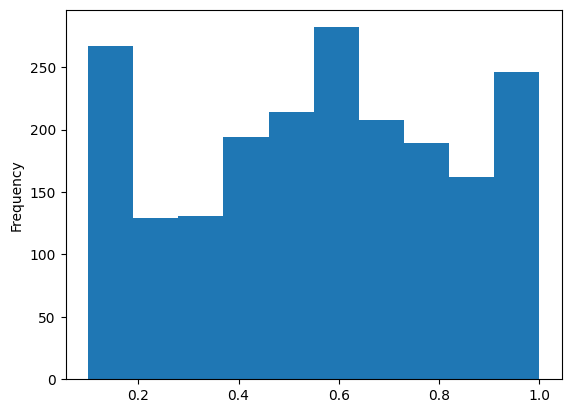